<a href="https://colab.research.google.com/github/RyanRash/NewRepoforAudioReactive/blob/main/Audio_reactive_Latent_Interpolations_with_StyleGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook shows a simple workflow to render audio-reactive latent interpolations as described in [this paper](https://wavefunk.xyz/assets/audio-reactive-stylegan/paper.pdf) for the NeurIPS 2020 [Workshop on Machine Learning for Creativity & Design](https://neurips2020creativity.github.io/).

A very basic, WIP notebook to choose latent vectors for the interpolations can be found [here](https://colab.research.google.com/drive/1BJ3wk_SkCftjLF2jJXOt0OsiETy1F1bz) (for now it's only verified to work for Linux, as it requires forwarding X11 to an SSH session from your local machine).

You can find a slightly simpler description of the paper's main contributions in this [blog post](https://wavefunk.xyz/audio-reactive-stylegan).

### For NFT enthusiasts, please read [this thread](https://twitter.com/dvsch/status/1387060713131282433)

# Preparation

Upload an audio file

In [ ]:
from google.colab import files
uploaded = files.upload()
audio_file = list(uploaded.keys())[0]
print('User uploaded file "{name}" with length {length} bytes'.format(name=audio_file, length=len(uploaded[audio_file])))

Saving wavefunk - naamloos.flac to wavefunk - naamloos.flac
User uploaded file "wavefunk - naamloos.flac" with length 11970635 bytes


Download all the required dependencies

In [ ]:
!nvidia-smi --query-gpu=name,memory.free --format=csv,noheader
!echo
%tensorflow_version 1.x
!git clone https://github.com/NVlabs/stylegan2.git
!git clone https://github.com/NVlabs/stylegan2-ada.git
!git clone https://github.com/rosinality/stylegan2-pytorch
!git clone https://github.com/JCBrouwer/maua-stylegan2
!mv "$audio_file" maua-stylegan2/
%cd /content/maua-stylegan2
!pip install librosa madmom kornia Ninja matplotlib scikit-image gdown
!pip install torch==1.7.1 torchvision==0.8.2
%matplotlib inline
!wget https://github.com/kkroening/ffmpeg-python/archive/0.2.0.zip
!unzip 0.2.0.zip
!mv ffmpeg-python-0.2.0/ffmpeg ./
!rm -rf ffmpeg-python-0.2.0/ 0.2.0.zip

Tesla T4, 15109 MiB

TensorFlow 1.x selected.
Cloning into 'stylegan2'...
remote: Enumerating objects: 131, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 131 (delta 0), reused 1 (delta 0), pack-reused 127
Receiving objects: 100% (131/131), 593.76 KiB | 24.74 MiB/s, done.
Resolving deltas: 100% (58/58), done.
Cloning into 'stylegan2-ada'...
remote: Enumerating objects: 71, done.
remote: Total 71 (delta 0), reused 0 (delta 0), pack-reused 71
Unpacking objects: 100% (71/71), done.
Cloning into 'stylegan2-pytorch'...
remote: Enumerating objects: 383, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 383 (delta 3), reused 9 (delta 3), pack-reused 372
Receiving objects: 100% (383/383), 122.51 MiB | 42.43 MiB/s, done.
Resolving deltas: 100% (190/190), done.
Cloning into 'maua-stylegan2'...
remote: Enumerating objects: 965, done.
remote: Counting objects: 100% (221/22

Download a stylegan network checkpoint (alternatively upload your own, drag and drop to files menu on left).

good places to find networks:

https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada/pretrained/

https://github.com/justinpinkney/awesome-pretrained-stylegan2

In [ ]:
# FFHQ
# !wget https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada/pretrained/ffhq.pkl

# Derrick Schultz's Frea Buckler network (from awesome-pretrained-stylegan2)
!gdown https://drive.google.com/u/0/uc?id=1YzZemZAp7BVW701_BZ7uabJWJJaS2g7v

Downloading...
From: https://drive.google.com/u/0/uc?id=1YzZemZAp7BVW701_BZ7uabJWJJaS2g7v
To: /content/maua-stylegan2/FreaGAN.pkl
382MB [00:02, 189MB/s]


Convert tensorflow .pkl checkpoint to pytorch .pt checkpoint

`--repo` argument must coincide with the repository that the .pkl was trained with

In [ ]:
# !python ../stylegan2-pytorch/convert_weight.py --gen ffhq.pkl --repo ../stylegan2-ada/
!python ../stylegan2-pytorch/convert_weight.py --gen FreaGAN.pkl --repo ../stylegan2/

Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Compiling... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Compiling... Loading... Done.
tensor(0.0001, device='cuda:0')


# Audio-reactive

This is where the functions that make the video react to the music are defined.

You can find more examples of these functions [here](https://github.com/JCBrouwer/maua-stylegan2/tree/master/audioreactive/examples)




First initialize things that will be resused multiple times

n.b. get_noise() will be called >10 times for different sizes, so preparing things beforehand can save *a lot of* time

In [ ]:
import torch as th
import librosa as rosa
import audioreactive as ar

def initialize(args):
    # exercise for the reader:
    # install https://github.com/deezer/spleeter
    # split your audio file into 4 tracks
    # then load them individually for higher-quality onsets/chroma/etc. e.g.:
    #     !spleeter separate $audio_file -p spleeter:4stems
    #     drums, drum_sr = rosa.load("/path/to/drum_file.wav")

    args.lo_onsets = ar.onsets(args.audio, args.sr, args.n_frames, fmax=150, smooth=3)
    args.hi_onsets = ar.onsets(args.audio, args.sr, args.n_frames, fmin=150, smooth=3)

    print("onsets:")
    ar.plot_signals([args.hi_onsets, args.lo_onsets])

    return args

/usr/local/lib/python3.7/dist-packages/kornia/augmentation/augmentation.py:1833: DeprecationWarning: GaussianBlur is no longer maintained and will be removed from the future versions. Please use RandomGaussianBlur instead.
  category=DeprecationWarning,
/usr/local/lib/python3.7/dist-packages/madmom/processors.py:23: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import MutableSequence


Create audioreactive latents default shape for 1024px network is: [n_frames, 18, 512]

In [ ]:
def get_latents(selection, args):
    chroma = ar.chroma(args.audio, args.sr, args.n_frames)

    print("chroma:")
    ar.plot_spectra([chroma], chroma=True)

    latents = ar.spline_loops(selection, args.n_frames, 1).float()
    latents = ar.gaussian_filter(latents, 4)

    lo_onsets = args.lo_onsets[:, None, None]
    hi_onsets = args.hi_onsets[:, None, None]

    latents = hi_onsets * selection[[-4]] + (1 - hi_onsets) * latents
    latents = lo_onsets * selection[[-7]] + (1 - lo_onsets) * latents

    latents = ar.gaussian_filter(latents, 2, causal=0.2)

    return latents

Create audioreactive noise

In [ ]:
def get_noise(height, width, scale, num_scales, args):
    if width > 256:
        return None

    lo_onsets = args.lo_onsets[:, None, None, None].cuda()
    hi_onsets = args.hi_onsets[:, None, None, None].cuda()

    noise_noisy = ar.gaussian_filter(th.randn((args.n_frames, 1, height, width), device="cuda"), 5)
    noise = ar.gaussian_filter(th.randn((args.n_frames, 1, height, width), device="cuda"), 128)

    if width < 128:
        noise = lo_onsets * noise_noisy + (1 - lo_onsets) * noise
    if width > 32:
        noise = hi_onsets * noise_noisy + (1 - hi_onsets) * noise

    noise /= noise.std()

    return noise.cpu()

Create audioreactive network bends (here the width is doubled for 1920x1080 output).

In [ ]:
def get_bends(args):
    transform = th.nn.Sequential(
        th.nn.ReplicationPad2d((2, 2, 0, 0)), ar.AddNoise(0.025 * th.randn(size=(1, 1, 4, 8), device="cuda")),
    )
    return [{"layer": 0, "transform": transform}]

Try to empty GPU memory each time you run generate()

Sometimes it doesn't get cleared completely

In [ ]:
print("Time                     GPU        Used      Total")
!nvidia-smi --query-gpu=timestamp,name,memory.used,memory.free --format=csv,noheader
import gc
import torch
gc.collect()
torch.cuda.empty_cache()
!nvidia-smi --query-gpu=timestamp,name,memory.used,memory.free --format=csv,noheader

Time                     GPU        Used      Total
2021/06/26 18:42:14.832, Tesla T4, 948 MiB, 14161 MiB
2021/06/26 18:42:15.138, Tesla T4, 948 MiB, 14161 MiB


Render the final video!

onsets:


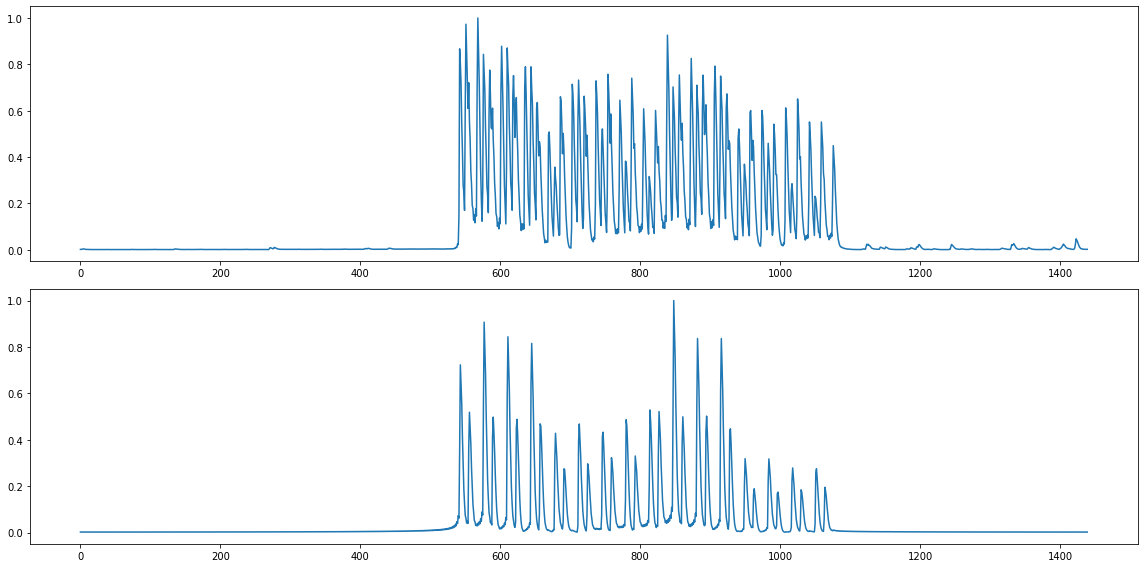


generating latents...
chroma:


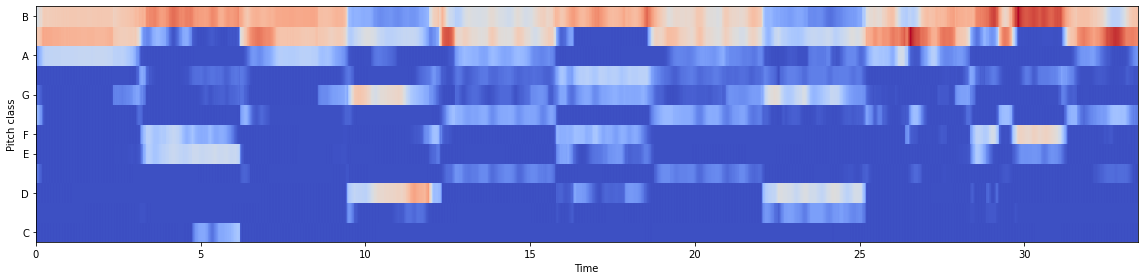

[1440, 18, 512] amplitude=0.47147247195243835

generating noise...
[1440, 1, 4, 4] amplitude=0.4000000059604645
[1440, 1, 8, 8] amplitude=0.4000000059604645
[1440, 1, 8, 8] amplitude=0.4000000059604645
[1440, 1, 16, 16] amplitude=0.4000000059604645
[1440, 1, 16, 16] amplitude=0.3999999761581421
[1440, 1, 32, 32] amplitude=0.4000000059604645
[1440, 1, 32, 32] amplitude=0.4000000059604645
[1440, 1, 64, 64] amplitude=0.3999999761581421
[1440, 1, 64, 64] amplitude=0.4000000059604645
[1440, 1, 128, 128] amplitude=0.4000000059604645
[1440, 1, 128, 128] amplitude=0.40000003576278687
[1440, 1, 256, 256] amplitude=0.4000000059604645
[1440, 1, 256, 256] amplitude=0.3999999761581421


preprocessing took 34.90s

rendering 1440 frames...


100%|███████████████████████████████████████| 1440/1440 [02:13<00:00, 10.77it/s]



total time taken: 3.03 minutes


In [ ]:
from generate_audiovisual import generate
# you want to set the batch size and ffmpeg_preset as large and as slow as your GPU can handle
# larger batches => faster, slower preset => smaller + better quality video files
generate(
  ckpt="./FreaGAN.pt",
  audio_file=audio_file,
  output_dir="../",
  out_size=1024, # at the moment only 512x512, 1024x1024, 1920x1080 outputs are supported (out_size = 512, 1024, or 1920 respectively)
  G_res=1024,
  batch=4,  # CUDA out of memory errors => smaller batch (also try running the previous cell, to clear some GPU memory)
  ffmpeg_preset="faster",  # RAM crashes => faster preset (see https://trac.ffmpeg.org/wiki/Encode/H.264)
  fps=24,
  duration=60, # remove this line for full video
  initialize=initialize,
  get_latents=get_latents,
  get_noise=get_noise,
  # get_bends=get_bends, # if you're running a 1024px network you can uncomment this for 1920x1080 output
)

You can now upload a new audio file using the following cell and then render it by only executing the previous cell.

In [ ]:
from google.colab import files
uploaded = files.upload()
audio_file = list(uploaded.keys())[0]
print('User uploaded file "{name}" with length {length} bytes'.format(name=audio_file, length=len(uploaded[audio_file])))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

P.S.

To load seeds from NVIDIA's official stylegan repositories (or forks thereof):

In [ ]:
import numpy as np

seed = 1000
nvlatent = np.random.RandomState(seed).randn(1, 512) # shape = [1, 512]
latent1 = np.stack([nvlatents]*18, axis=1) # shape = [1, 18, 512]
# repeat for some more seeds
# ...
latents = np.concatenate([latent1, latent2, ..., latent11], axis=0) # shape = [12, 18, 512]

np.save("my_latents.npy", latents)

This assumes a default 1024x1024 network (18 layers) with a latent dimension of 512. You'll need to adjust some numbers above if your network has a different resolution or latent_dim.

Now `my_latents.npy` can be loaded to `generate()` as an argument `latent_file="my_latents.npy"`